In [51]:
import json

with open('datas.json', 'r') as file:
    datas=json.load(file)
map_name="map_14"
map=datas[map_name]["map"]

In [2]:
# "map_1" - "map_5" ---- cliff
# "map_6" - "map_10" ---- marsh
# "map_11" - "map_15" ---- complexe

## 以下是游戏本体（随机运行版本）

In [24]:
# Define grid cell size and margin
CELL_SIZE = 50
MARGIN = 5

# Define colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)
YELLOW = (255, 255, 0)
GREY = (140, 140, 140)

import random
class GridWorld:
    def __init__(self, width, height, wall_positions=None, goal_positions=None, cliff_positions=None, marsh_positions=None):
        self.width = width
        self.height = height
        self.player_position = (datas[map_name]["start_place_x"], datas[map_name]["start_place_y"])
        self.wall_positions = wall_positions if wall_positions else []
        self.cliff_positions = cliff_positions if cliff_positions else []
        self.marsh_positions = marsh_positions if marsh_positions else []
        self.goal_positions = goal_positions if goal_positions else []

    def move_player(self, direction):
        x, y = self.player_position
        if direction == "up":
            y = max(0, y - 1)
        elif direction == "down":
            y = min(self.height - 1, y + 1)
        elif direction == "left":
            x = max(0, x - 1)
        elif direction == "right":
            x = min(self.width - 1, x + 1)
        
        # Check if the new position is blocked
        if (x, y) in self.cliff_positions :
            self.player_position = (datas[map_name]["start_place_x"], datas[map_name]["start_place_y"])
        elif (x, y) not in self.wall_positions:
            self.player_position = (x, y)
        return self.player_position in self.goal_positions

    def print_grid(self):
        for y in range(self.height):
            row = ""
            for x in range(self.width):
                if (x, y) == self.player_position:
                    row += "P"
                elif (x, y) in self.goal_positions:
                    row += "G"
                elif (x, y) in self.wall_positions:
                    row += "B"
                else:
                    row += "."
            print(row)
    def is_game_over(self):
        return self.player_position in self.goal_positions

In [52]:
import pygame


def draw_grid(screen, grid_world):
    for y in range(grid_world.height):
        for x in range(grid_world.width):
            color = WHITE
            if (x, y) == (0,0):
                color = GREY
            if (x, y) in grid_world.goal_positions:
                color = YELLOW
            elif (x, y) in grid_world.wall_positions:
                color = GREEN
            elif (x, y) in grid_world.cliff_positions:
                color = RED
            elif (x, y) in grid_world.marsh_positions:
                color = BLUE

            pygame.draw.rect(screen, color, [(MARGIN + CELL_SIZE) * x + MARGIN, (MARGIN + CELL_SIZE) * y + MARGIN, CELL_SIZE, CELL_SIZE])

def main():
    
    # Read the map
    n=0 #dimension of the map
    wall=[]
    cliff=[]
    marsh=[]
    goal=[]
    
    for k in map:
        n=n+1
    for i in range(n):
        for j in range(n):
            if map[i][j] == 1:
                wall.append((j,i))
            elif map[i][j] == 2:
                cliff.append((j,i))
            elif map[i][j] == 3:
                marsh.append((j,i))
            elif map[i][j] == 4:
                goal.append((j,i))
            
    
    grid_world = GridWorld(10, 10, wall, goal, cliff, marsh)
    directions = ["up", "down", "left", "right"]

    # Set up the display
    screen = pygame.display.set_mode([(CELL_SIZE + MARGIN) * grid_world.width + MARGIN, (CELL_SIZE + MARGIN) * grid_world.height + MARGIN])
    pygame.display.set_caption("GridWorld")

    # Main loop
    running = True
    clock = pygame.time.Clock()
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Random agent simulation
        if not grid_world.is_game_over():
            direction = random.choice(directions)
            grid_world.move_player(direction)

        # Draw the grid
        screen.fill(BLACK)
        draw_grid(screen, grid_world)

        # Update the display
        pygame.display.flip()

        # Limit the frame rate
        clock.tick(60)

    # Quit pygame
    pygame.quit()

main()

## 以下是Qlearning核心

In [30]:
class QLearningAgent:
    def __init__(self, grid_world, alpha=0.1, gamma=0.95, epsilon=0.1):
        self.grid_world = grid_world
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.actions = ["up", "down", "left", "right"]

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0)

    def update_q_value(self, state, action, new_value):
        self.q_table[(state, action)] = new_value

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, action) for action in self.actions]
            max_q_value = max(q_values)
            max_q_indices = [i for i in range(len(q_values)) if q_values[i] == max_q_value]
            return self.actions[random.choice(max_q_indices)]

    def learn(self, state, action, reward, next_state):
        current_q_value = self.get_q_value(state, action)
        next_q_values = [self.get_q_value(next_state, a) for a in self.actions] 
        max_next_q_value = max(next_q_values)
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * max_next_q_value - current_q_value)
        self.update_q_value(state, action, new_q_value)

# 以下是Sarsa核心

In [31]:
# Create a SARSA agent class
class SarsaAgent:
    def __init__(self, grid_world, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.grid_world = grid_world
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.actions = ["up", "down", "left", "right"]

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0)

    def update_q_value(self, state, action, new_value):
        self.q_table[(state, action)] = new_value

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, a) for a in self.actions]
            max_q_value = max(q_values)
            max_actions = [a for a, q in zip(self.actions, q_values) if q == max_q_value]
            return random.choice(max_actions)

    def learn(self, state, action, reward, next_state, next_action):
        current_q_value = self.get_q_value(state, action)
        next_q_value = self.get_q_value(next_state, next_action)
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * next_q_value - current_q_value)
        self.update_q_value(state, action, new_q_value)
     

## 训练

In [32]:
import pygame
import matplotlib.pyplot as plt
import numpy as np
import pickle
def Experiment_single(num_episodes, alpha, gamma, epsilon):
     # Read the map
    n=0 #dimension of the map
    wall=[]
    cliff=[]
    marsh=[]
    goal=[]
    
    for k in map:
        n=n+1
    for i in range(n):
        for j in range(n):
            if map[i][j] == 1:
                wall.append((j,i))
            elif map[i][j] == 2:
                cliff.append((j,i))
            elif map[i][j] == 3:
                marsh.append((j,i))
            elif map[i][j] == 4:
                goal.append((j,i))
            
    grid_worldQ = GridWorld(10, 10, wall, goal, cliff, marsh)
    
    grid_worldA = GridWorld(10, 10, wall, goal, cliff, marsh)


    agentQ = QLearningAgent(grid_worldQ, alpha=alpha, gamma=gamma, epsilon=epsilon) #to experiment agent learning with diff ["parameters"]s

    agentA = SarsaAgent(grid_worldA, alpha=alpha, gamma=gamma, epsilon=epsilon)
    

    steps_per_episodeQ = []
    steps_per_episodeA = []
    
    for episodeQ in range(num_episodes):
        grid_worldQ.player_position = (datas[map_name]["start_place_x"], datas[map_name]["start_place_y"])
        steps = 0
        while not grid_worldQ.is_game_over() and steps < datas[map_name]["parameters"]["step_limit"]:
            state = grid_worldQ.player_position
            action = agentQ.choose_action(state)
            reached_goal = grid_worldQ.move_player(action)
            next_state = grid_worldQ.player_position
            if reached_goal:
                reward = datas[map_name]["parameters"]["reward_final"]
            elif grid_worldQ.player_position in grid_worldQ.marsh_positions:
                reward = datas[map_name]["parameters"]["reward_marsh"]
            else:
                reward = datas[map_name]["parameters"]["reward_road"]
            agentQ.learn(state, action, reward, next_state)
            if episodeQ < datas[map_name]["parameters"]["steps_for_epsilon_stage1"]:
                agentQ.epsilon = max(agentQ.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate1"]), datas[map_name]["parameters"]["epsilon_min"])
            else:
                agentQ.epsilon = max(agentQ.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate2"]*episodeQ), datas[map_name]["parameters"]["epsilon_min"])
            steps += 1
        steps_per_episodeQ.append(steps)
        
        if episodeQ % (datas[map_name]["parameters"]["episodes"]/20) == 0:        
            # Save the learned policy
            with open(f"{map_name}_q_learning_episode_{episodeQ}.pkl", "wb") as f:
                pickle.dump(agentQ.q_table, f)
        if episodeQ == num_episodes-(datas[map_name]["parameters"]["episodes"]/20):
            print("Qlearning:",steps)
    
    mat = np.zeros((10,10))
    mat_d = np.zeros((10,10), dtype=str)
    for ((x,y), d), v in agentQ.q_table.items():
        mat[y, x] = v
        mat_d[y, x] = d
    print("qlearning")
    print(mat.astype(int))

    #for l in sorted(list(agentQ.q_table.items())):
    #    print(l)
    for episodeA in range(num_episodes):
        grid_worldA.player_position = (datas[map_name]["start_place_x"], datas[map_name]["start_place_y"])
        steps = 0
        while not grid_worldA.is_game_over() and steps < datas[map_name]["parameters"]["step_limit"]:
            state = grid_worldA.player_position
            action = agentA.choose_action(state)
            reached_goal = grid_worldA.move_player(action)
            next_state = grid_worldA.player_position
            if reached_goal:
                reward = datas[map_name]["parameters"]["reward_final"]
            elif grid_worldA.player_position in grid_worldA.marsh_positions:
                reward = datas[map_name]["parameters"]["reward_marsh"]
            else:
                reward = datas[map_name]["parameters"]["reward_road"]
            next_action = agentA.choose_action(next_state)
            agentA.learn(state, action, reward, next_state, next_action)
            if episodeA < datas[map_name]["parameters"]["steps_for_epsilon_stage1"]:
                agentA.epsilon = max(agentA.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate1"]), datas[map_name]["parameters"]["epsilon_min"])
            else:
                agentA.epsilon = max(agentA.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate2"]*episodeA), datas[map_name]["parameters"]["epsilon_min"])
            steps += 1
        steps_per_episodeA.append(steps)

        if episodeA % (datas[map_name]["parameters"]["episodes"]/20) == 0:        
            # Save the learned policy
            with open(f"{map_name}_sarsa_episode_{episodeA}.pkl", "wb") as f:
                pickle.dump(agentA.q_table, f)
        if episodeA == num_episodes-(datas[map_name]["parameters"]["episodes"]/20):
            print("Sarsa:",steps)
            
    mat = np.zeros((10,10))
    mat_d = np.zeros((10,10), dtype=str)
    for ((x,y), d), v in agentA.q_table.items():
        mat[y, x] = v
        mat_d[y, x] = d
    print("sarsa")
    print(mat.astype(int))

    #for l in sorted(list(agentA.q_table.items())):
    #    print(l)
    # Plot the graph of steps per episode
    plt.plot(steps_per_episodeQ,color='blue', alpha=0.8,label='Q-Learning')
    plt.plot(steps_per_episodeA,color='orange', alpha=0.8,label='Sarsa')
    x=[datas[map_name]["parameters"]["steps_for_epsilon_stage1"],datas[map_name]["parameters"]["steps_for_epsilon_stage1"]]
    y=[0,datas[map_name]["parameters"]["step_limit"]]
    plt.plot(x,y, color='red', alpha=0.8, label='stage_dividing_line')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps per Episode for Q-Learning Agent and Sarsa Agent')
    plt.legend()
    plt.yscale("log")
    plt.show()

Qlearning: 18
qlearning
[[8189 8154 8154 8091 8121 8294 8499 8915 8915 9126]
 [8106 8189 8324 8121 8499 8589 8499 8706 9219 9219]
 [8238 8324 8357 8499 8706 8499 8889 9100 9007 9313]
 [8560 8473 8443 8529 8499 9007 9219 9007 9100 9504]
 [8647 8616 8825 8616 8889 9100 9313 9219 9313 9602]
 [8647 8825 8616 9007 8915 8889 9100 9385 9483 9602]
 [8825 8915 8706 8915 9078 8982 9385 9408 9385 9799]
 [8915 9126 9219 9126 9219 9194 9291 9385 9602 9898]
 [9126 8915 9126 9408 9194 9291 9700 9799 9898 9799]
 [9126 9313 9219 9313 9602 9504 9602 9799 9999    0]]
Sarsa: 18
sarsa
[[ 8184  2627 -1391 -1089 -2078 -1884 -1740 -1576 -1435  -740]
 [ 7141  3439   943   304 -1148 -2093  -771  -988  -798 -1163]
 [ 8473  5815   413  -576  -658  -914  -608 -1553   -87  -630]
 [ 8560  8357  1655   284   808    94    34   136  -513   115]
 [ 8307  6093  7598  1274  3534  2366  2469  1267   596  4624]
 [ 8500  7663  4882  3648  1932  5129  4840  2689  4401  4709]
 [ 8695  7961  6663  5410  4425  7177  4903  5445  

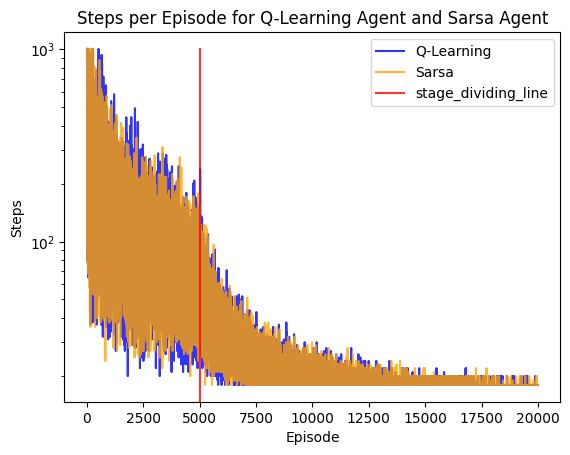

In [33]:
Experiment_single(num_episodes=datas[map_name]["parameters"]["episodes"], alpha=datas[map_name]["parameters"]["alpha"], gamma=datas[map_name]["parameters"]["gamma"], epsilon=datas[map_name]["parameters"]["epsilon"])

In [26]:
import pygame
import matplotlib.pyplot as plt
import numpy as np
import pickle
def Experiment_step(num_episodes, alpha, gamma, epsilon):
    # Read the map
    n=0 #dimension of the map
    wall=[]
    cliff=[]
    marsh=[]
    goal=[]
    
    for k in map:
        n=n+1
    for i in range(n):
        for j in range(n):
            if map[i][j] == 1:
                wall.append((j,i))
            elif map[i][j] == 2:
                cliff.append((j,i))
            elif map[i][j] == 3:
                marsh.append((j,i))
            elif map[i][j] == 4:
                goal.append((j,i))
            
    grid_worldQ = GridWorld(10, 10, wall, goal, cliff, marsh)
    
    grid_worldA = GridWorld(10, 10, wall, goal, cliff, marsh)


    agentQ = QLearningAgent(grid_worldQ, alpha=alpha, gamma=gamma, epsilon=epsilon) #to experiment agent learning with diff ["parameters"]s

    agentA = SarsaAgent(grid_worldA, alpha=alpha, gamma=gamma, epsilon=epsilon)
    

    steps_per_episodeQ = []
    steps_per_episodeA = []
    q_means=[]
    a_means=[]
    q_stds=[]
    a_stds=[]
    
    
    for i in range(10):
        for episodeQ in range(num_episodes):
            grid_worldQ.player_position = (datas[map_name]["start_place_y"], datas[map_name]["start_place_y"])
            steps = 0
            while not grid_worldQ.is_game_over() and steps < datas[map_name]["parameters"]["step_limit"]:
                state = grid_worldQ.player_position
                action = agentQ.choose_action(state)
                reached_goal = grid_worldQ.move_player(action)
                next_state = grid_worldQ.player_position
                if reached_goal:
                    reward = datas[map_name]["parameters"]["reward_final"]
                elif grid_worldQ.player_position in grid_worldQ.marsh_positions:
                    reward = datas[map_name]["parameters"]["reward_marsh"]
                else:
                    reward = datas[map_name]["parameters"]["reward_road"]
                agentQ.learn(state, action, reward, next_state)
                if episodeQ < datas[map_name]["parameters"]["steps_for_epsilon_stage1"]:
                    agentQ.epsilon = max(agentQ.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate1"]), datas[map_name]["parameters"]["epsilon_min"])
                else:
                    agentQ.epsilon = max(agentQ.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate2"]*episodeQ), datas[map_name]["parameters"]["epsilon_min"])
                steps += 1
            steps_per_episodeQ.append(steps)
        
            if episodeQ % (datas[map_name]["parameters"]["episodes"]/20) == 0:        
                # Save the learned policy
                with open(f"{map_name}_q_learning_episode_{episodeQ}.pkl", "wb") as f:
                    pickle.dump(agentQ.q_table, f)
                    
        q_means.append(np.mean(steps_per_episodeQ[-21:-1]))
        q_stds.append(steps_per_episodeQ[-21:-1])
        steps_per_episodeQ=[]
                
        for episodeA in range(num_episodes):
            grid_worldA.player_position = (datas[map_name]["start_place_x"], datas[map_name]["start_place_y"])
            steps = 0
            while not grid_worldA.is_game_over() and steps < datas[map_name]["parameters"]["step_limit"]:
                state = grid_worldA.player_position
                action = agentA.choose_action(state)
                reached_goal = grid_worldA.move_player(action)
                next_state = grid_worldA.player_position
                if reached_goal:
                    reward = datas[map_name]["parameters"]["reward_final"]
                elif grid_worldA.player_position in grid_worldA.marsh_positions:
                    reward = datas[map_name]["parameters"]["reward_marsh"]
                else:
                    reward = datas[map_name]["parameters"]["reward_road"]
                next_action = agentA.choose_action(next_state)
                agentA.learn(state, action, reward, next_state, next_action)
                if episodeA < datas[map_name]["parameters"]["steps_for_epsilon_stage1"]:
                    agentA.epsilon = max(agentA.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate1"]), datas[map_name]["parameters"]["epsilon_min"])
                else:
                    agentA.epsilon = max(agentA.epsilon*(1-datas[map_name]["parameters"]["epsilon_decay_rate2"]*episodeA), datas[map_name]["parameters"]["epsilon_min"])
                steps += 1
            steps_per_episodeA.append(steps)

            if episodeA % (datas[map_name]["parameters"]["episodes"]/20) == 0:        
                # Save the learned policy
                with open(f"{map_name}_sarsa_episode_{episodeA}.pkl", "wb") as f:
                    pickle.dump(agentA.q_table, f)
                    
        a_means.append(np.mean(steps_per_episodeA[-21:-1]))
        a_stds.append((steps_per_episodeA[-21:-1]))
        steps_per_episodeA=[]
              
    q_mean=np.mean(q_means)
    a_mean=np.mean(a_means)
    q_std=np.std(q_stds)
    a_std=np.std(a_stds)
    print("q_mean:",q_mean,"   std:",q_std)
    print("a_mean:",a_mean,"   std:",a_std)

In [27]:
Experiment_step(num_episodes=datas[map_name]["parameters"]["episodes"], alpha=datas[map_name]["parameters"]["alpha"], gamma=datas[map_name]["parameters"]["gamma"], epsilon=datas[map_name]["parameters"]["epsilon"])

q_mean: 20.0    std: 0.0
a_mean: 30.005000000000003    std: 0.0705336798983294


## 接下来运行

In [38]:
def SimulationQlearningAgent(episodes):
   # Read the map
    n=0 #dimension of the map
    wall=[]
    cliff=[]
    marsh=[]
    goal=[]
    
    for k in map:
        n=n+1
    for i in range(n):
        for j in range(n):
            if map[i][j] == 1:
                wall.append((j,i))
            elif map[i][j] == 2:
                cliff.append((j,i))
            elif map[i][j] == 3:
                marsh.append((j,i))
            elif map[i][j] == 4:
                goal.append((j,i))
            
    
    grid_world = GridWorld(10, 10, wall, goal, cliff, marsh)

    agent = QLearningAgent(grid_world, epsilon=datas[map_name]["parameters"]["epsilon_min"])

    # Load the learned policy
    episode=episodes
    with open(f"{map_name}_q_learning_episode_{episode}.pkl", "rb") as f:
        agent.q_table = pickle.load(f)
        for l in sorted(list(agent.q_table.items())):
            print(l)

    # Set up the display
    screen = pygame.display.set_mode([(CELL_SIZE + MARGIN) * grid_world.width + MARGIN, (CELL_SIZE + MARGIN) * grid_world.height + MARGIN])
    pygame.display.set_caption("GridWorld")

    # Main loop
    running = True
    clock = pygame.time.Clock()
    visited_positions = []
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Use learned policy for agent simulation
        if not grid_world.is_game_over():
            state = grid_world.player_position
            action = agent.choose_action(state)  # why not taken from the policy and the state
            grid_world.move_player(action)
            visited_positions.append(grid_world.player_position)

        # Draw the grid
        screen.fill(BLACK)
        draw_grid(screen, grid_world)

        # Draw visited positions with a changing color from dense to transparent
        for i, pos in enumerate(visited_positions):
            x, y = pos
            alpha = int(100 + 155 * (i / len(visited_positions)))
            color = (255, 200, 200, alpha)  # Light red with changing transparency
            temp_surface = pygame.Surface((CELL_SIZE, CELL_SIZE), pygame.SRCALPHA)
            pygame.draw.rect(temp_surface, color, [0, 0, CELL_SIZE, CELL_SIZE])
            screen.blit(temp_surface, [(MARGIN + CELL_SIZE) * x + MARGIN, (MARGIN + CELL_SIZE) * y + MARGIN])

        # Update the display
        pygame.display.flip()

        # Limit the frame rate
        clock.tick(30)

    # Quit pygame
    pygame.quit()


In [39]:
def SimulationSarsaAgent(episodes):
    
    # Read the map
    n=0 #dimension of the map
    wall=[]
    cliff=[]
    marsh=[]
    goal=[]
    
    for k in map:
        n=n+1
    for i in range(n):
        for j in range(n):
            if map[i][j] == 1:
                wall.append((j,i))
            elif map[i][j] == 2:
                cliff.append((j,i))
            elif map[i][j] == 3:
                marsh.append((j,i))
            elif map[i][j] == 4:
                goal.append((j,i))
            
    grid_world = GridWorld(10, 10, wall, goal, cliff, marsh)                    
    agent = SarsaAgent(grid_world, epsilon=datas[map_name]["parameters"]["epsilon_min"])

    # Load the learned policy
    episode=episodes
    with open(f"{map_name}_sarsa_episode_{episode}.pkl", "rb") as f:
        agent.q_table = pickle.load(f)
        for l in sorted(list(agent.q_table.items())):
            print(l)

    # Set up the display
    screen = pygame.display.set_mode([(CELL_SIZE + MARGIN) * grid_world.width + MARGIN, (CELL_SIZE + MARGIN) * grid_world.height + MARGIN])
    pygame.display.set_caption("GridWorld")

    # Main loop
    running = True
    clock = pygame.time.Clock()
    visited_positions = []
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Use learned policy for agent simulation
        if not grid_world.is_game_over():
            state = grid_world.player_position
            action = agent.choose_action(state)
            grid_world.move_player(action)
            visited_positions.append(grid_world.player_position)

        # Draw the grid
        screen.fill(BLACK)
        draw_grid(screen, grid_world)

        # Draw visited positions with a changing color from dense to transparent
        for i, pos in enumerate(visited_positions):
            x, y = pos
            alpha = int(100 + 155 * (i / len(visited_positions)))
            color = (255, 200, 200, alpha)  # Light red with changing transparency
            temp_surface = pygame.Surface((CELL_SIZE, CELL_SIZE), pygame.SRCALPHA)
            pygame.draw.rect(temp_surface, color, [0, 0, CELL_SIZE, CELL_SIZE])
            screen.blit(temp_surface, [(MARGIN + CELL_SIZE) * x + MARGIN, (MARGIN + CELL_SIZE) * y + MARGIN])

        # Update the display
        pygame.display.flip()

        # Limit the frame rate
        clock.tick(30)

    # Quit pygame
    pygame.quit()

In [42]:
SimulationQlearningAgent(episodes=datas[map_name]["parameters"]["episodes"]*19//20)

(((0, 0), 'down'), 8189.642660838344)
(((0, 0), 'left'), 8106.746234229953)
(((0, 0), 'right'), 8189.642660838344)
(((0, 0), 'up'), 8106.746234229953)
(((0, 1), 'down'), 8268.687350279251)
(((0, 1), 'left'), 8189.642660838344)
(((0, 1), 'right'), 8273.376425089245)
(((0, 1), 'up'), 8106.746234229953)
(((0, 2), 'down'), 8473.421565938654)
(((0, 2), 'left'), 8268.687350279251)
(((0, 2), 'right'), 8238.95598493865)
(((0, 2), 'up'), 8189.642660838344)
(((0, 3), 'down'), 8560.021783776436)
(((0, 3), 'left'), 8473.421565938654)
(((0, 3), 'right'), 8324.389883776432)
(((0, 3), 'up'), 8268.687350279251)
(((0, 4), 'down'), 8647.496751289345)
(((0, 4), 'left'), 8560.021783776436)
(((0, 4), 'right'), 8529.686751289344)
(((0, 4), 'up'), 8473.421565938654)
(((0, 5), 'down'), 8735.85530433269)
(((0, 5), 'left'), 8647.496751289176)
(((0, 5), 'right'), 8616.85530433269)
(((0, 5), 'up'), 8560.02178377637)
(((0, 6), 'down'), 8825.106368012835)
(((0, 6), 'left'), 8735.85530433269)
(((0, 6), 'right'), 882

In [41]:
SimulationSarsaAgent(episodes=datas[map_name]["parameters"]["episodes"]*19//20)

(((0, 0), 'down'), 8168.062499876118)
(((0, 0), 'left'), 7900.682186482312)
(((0, 0), 'right'), 7548.068105991412)
(((0, 0), 'up'), 7872.21146425728)
(((0, 1), 'down'), 8242.881509313549)
(((0, 1), 'left'), 7985.054663157391)
(((0, 1), 'right'), 7120.125602681939)
(((0, 1), 'up'), 7839.921382823759)
(((0, 2), 'down'), 8472.14522634487)
(((0, 2), 'left'), 8115.411839635466)
(((0, 2), 'right'), 7565.9651912699155)
(((0, 2), 'up'), 8011.1857419031985)
(((0, 3), 'down'), 8559.078730260324)
(((0, 3), 'left'), 8335.304738708388)
(((0, 3), 'right'), 7795.132582917719)
(((0, 3), 'up'), 8068.8269099430445)
(((0, 4), 'down'), 8646.864171994508)
(((0, 4), 'left'), 8436.97869064709)
(((0, 4), 'right'), 8302.407720980842)
(((0, 4), 'up'), 8340.286011490536)
(((0, 5), 'down'), 8735.468064266572)
(((0, 5), 'left'), 8500.236216660249)
(((0, 5), 'right'), 8385.05960683979)
(((0, 5), 'up'), 8426.250400233608)
(((0, 6), 'down'), 8824.886592937031)
(((0, 6), 'left'), 8627.588604205805)
(((0, 6), 'right'),